# Cerinta 1 - Reprezentarea modelului de clasificare

In [6]:
from functools import reduce
from json import dumps
from math import inf, log
from operator import add
from os import listdir
from os.path import basename
from random import shuffle
import matplotlib.pyplot as plt

from nltk import download
from nltk.corpus import stopwords
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.stem import WordNetLemmatizer
from spacy import load

download('wordnet')
download('punkt')
download('stopwords')

[nltk_data] Downloading package wordnet to /home/teo/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /home/teo/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /home/teo/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [7]:
class NewsSummarisationModel:
	def __init__(self, stop_words_file):
		self._ALPHA = 1
		self._chars_to_remove = '012345679.,-~`|\\/:;\'"?![]()\n\"'
		self.class_words = {
			True: {},
			False: {}
		}
		self.class_app = {
			True: 0,
			False: 0
		}
		self.total_words = {
			True: 0,
			False: 0
		}

		self.total_sents = 0
		self.stop_pos = {'PART', 'DET', 'PUNCT', 'AUX'}

		self.wnl = WordNetLemmatizer()
		self.nlp = load('en')

		self.stop_words = set(stopwords.words('english')) | set(' ')
		with open(stop_words_file) as f:
			self.stop_words.union(set(token.replace('\n', '') for token in f))


	def _remove_chars(self, s):
		for ch in self._chars_to_remove:
			s = s.replace(ch, '')

		return s


	def _should_keep_token(self, tok, elim_stops, lemmatise):
		# if elim_stops:
		# 	if lemmatise:
		# 		return (tok.lemma_ not in self.stop_words
		# 			and tok.pos_ not in self.stop_pos
		# 			and not tok.is_stop)
		# 	else:
		# 		return tok not in self.stop_words

		# return True
		return tok not in self.stop_words if elim_stops else True


	def parse_sents(self, sents, elim_stops, lemmatise):
		lems = []
		for sent in sents:
			tokens = word_tokenize(sent) if lemmatise else sent.split()
			for tok in tokens:
				if self._should_keep_token(tok, elim_stops, lemmatise):
					if lemmatise:
						lem = self.wnl.lemmatize(self._remove_chars(tok).lower())
					else:
						lem = tok

					if lem and lem not in self.stop_words:
						lems.append(lem)

		return lems


	def _add_lems_to_class(self, lems, clss):
		for lem in lems:
			if lem in self.class_words[clss]:
				self.class_words[clss][lem] += 1
			else:
				self.class_words[clss][lem] = 1


	def add_file_summary(self, file, summ, elim_stops, lemmatise):
		# TODO: pune totu' in with-uri
		with open(summ) as f:		
			summ_str = f.read()
		with open(file) as f:
			file_sent = sent_tokenize(f.read())

		file_sent_keep = list(filter(lambda s: s in summ_str, file_sent))
		self.class_app[True] += len(file_sent_keep)
		self.total_sents += len(file_sent_keep)

		summ_lems = self.parse_sents(file_sent_keep, elim_stops, lemmatise)
		self.total_words[True] += len(summ_lems)
		self._add_lems_to_class(summ_lems, True)

		file_sent_drop = list(filter(lambda s: s not in summ_str, file_sent))
		self.class_app[False] += len(file_sent_drop)
		self.total_sents += len(file_sent_drop)

		drop_lems = self.parse_sents(file_sent_drop, elim_stops, lemmatise)
		self.total_words[False] += len(drop_lems)
		self._add_lems_to_class(drop_lems, False)


	def _compute_log_prob(self, word, cl):
		return log(
			(self.class_words[cl].get(word, 0) + self._ALPHA)
			/ (self.total_words[cl] + len(self.class_words) * self._ALPHA)
		)


	def _make_pred(self, sent, elim_stops, lemmatise):
		lems = self.parse_sents([sent], elim_stops, lemmatise)
		max_prob = -inf

		for cl in self.class_words:
			cl_prob = reduce(
				add,
				map(lambda l: self._compute_log_prob(l, cl), lems),
				0
			) + log(self.class_app[cl] / self.total_sents)

			if max_prob < cl_prob:
				max_prob = cl_prob
				pred = cl
		
		return pred, max_prob


	def run_inference(self, file, elim_stops, lemmatise):
		with open(file) as f:
			sents = sent_tokenize(f.read())
		keeps = list(map(
			lambda s: self._make_pred(s, elim_stops, lemmatise),
			sents
		))
		predicted_sents = zip(sents, keeps)

		for pred, _ in keeps:
			if pred:
				return [sent for sent, keep in predicted_sents if keep[0]]

		predicted_sents = list(predicted_sents)
		predicted_sents.sort(key=lambda p: p[1][1])
		return [predicted_sents[0][0]]


	def print(self, file):
		with open(file, 'w') as f:
			f.write("class_app:\n")
			f.write(dumps(self.class_app, indent=4) + '\n')
			f.write("class_words:\n")
			f.write(dumps(self.class_words, indent=4) + '\n')

In [9]:
def test_classification(path, stop_words_file, elim_stops, lemmatise):
    model, test_files = create_classification_model(
        path,
        stop_words_file,
        elim_stops,
        lemmatise
    )
    recalls = []
    precs = []
    f1 = []

    model.print('out')

    for test in test_files:
        _, _, clss, file = test.split('/')
        
        pred_summ = model.run_inference(
            f'{path}/News Articles/{clss}/{file}',
            elim_stops,
            lemmatise
        )

        pred_lems = set(model.parse_sents(pred_summ, elim_stops, lemmatise))
        with open(f'{path}/Summaries/{clss}/{file}') as f:
            true_sent = sent_tokenize(f.read())
            true_lems = set(model.parse_sents(
                true_sent,
                elim_stops,
                lemmatise
            ))
        common_lem = pred_lems & true_lems

        recalls.append(len(common_lem) / len(true_lems))
        precs.append(len(common_lem) / len(pred_lems))
        # f1.append(2 * recalls[len(recalls) - 1] * precs[len(precs) - 1] / (recalls[len(recalls) - 1] + precs[len(precs) - 1]))

    print(f'Average precision = {reduce(add, precs, 0) / len(precs)}')
    print(f'Average recall = {reduce(add, recalls, 0) / len(recalls)}')
    # print(f'Average F1 = {reduce(add, f1, 0) / len(f1)}')

    plt.figure(figsize=(23,5))
    plt.plot(range(len(test_files)), precs, label='Precision')
    plt.plot(range(len(test_files)), recalls, label='Recall')
    # plt.plot(range(len(test_files)), f1, label='F1')
    plt.xlabel('File index', fontsize=15)
    plt.ylabel('Percentage', fontsize=15)
    plt.legend(fontsize=15)
    plt.show()

In [8]:
def create_classification_model(path, stop_words_file, elim_stops, lemmatise):
    model = NewsSummarisationModel(stop_words_file)
    test_files = []

    for clss in listdir(f'{path}/News Articles'):
        files_in_class = listdir(f'{path}/News Articles/{clss}')
        shuffle(files_in_class)
        
        num_files = len(files_in_class)

        test_in_class = files_in_class[:int(num_files / 4)]
        train_files = files_in_class[int(num_files / 4):]
        test_files += list(map(lambda f: f'{path}/News Articles/{clss}/{f}', test_in_class))

        [model.add_file_summary(
            f'{path}/News Articles/{clss}/{f}',
            f'{path}/Summaries/{clss}/{f}',
            elim_stops,
            lemmatise
        )
            for f in train_files]
    
    return model, test_files

In [ ]:
def _get_train_test_files(path):
    train_files = []
    test_files = []

    for clss in listdir(f'{path}/News Articles'):
        files_in_class = list(map(
            lambda f: (f'{path}/News Articles/{clss}/{f}', f'{path}/Summaries/{clss}/{f}'),
            listdir(f'{path}/News Articles/{clss}')
        ))
        shuffle(files_in_class)

        num_files = len(files_in_class)
        num_tests = int(num_files / 4)

        test_files += files_in_class[:num_tests]
        train_files += files_in_class[num_tests:]

    return train_files, test_files, listdir(path)


def _run_tests(model, test_files, classes, elim_stops, lemmatise):
    # for file, test in test_files:


    return recalls, precs


def _plot_results(xs, precs, recalls):
    plt.figure(figsize=(23,5))
    plt.plot(xs, precs, label='Precision')
    plt.plot(xs, recalls, label='Recall')
    plt.xlabel('Training files', fontsize=15)
    plt.ylabel('Percentage', fontsize=15)
    plt.legend(fontsize=15)
    plt.title('ROUGE-1 Score', fontsize=15)
    plt.show()


def train_and_test(path, stop_words_file, elim_stops, lemmatise):
    model = NewsClassificationModel(stop_words_file)
    train_files, test_files, classes = _get_train_test_files(path)

    precs = []
    recalls = []
    xs = []
    i = 1

    for file, summ in train_files:
        if i % 100 == 0:
            xs.append(i)
            rec, prec = _run_tests(model, test_files, elim_stops, lemmatise)
            recalls.append(rec)
            precs.append(prec)

        model.add_file_summary(file, summ, elim_stops, lemmatise)
        i += 1

    xs.append(i)
    rec, prec = _run_tests(model, test_files, elim_stops, lemmatise)
    recalls.append(rec)
    precs.append(prec))

    _plot_results(xs, precs, recalls)

Testing classification: ELIMINATION + LEMMATISATION...
Average precision = 0.5722266649683531
Average recall = 0.5652155335504421
Average F1 = 0.5471674673204924


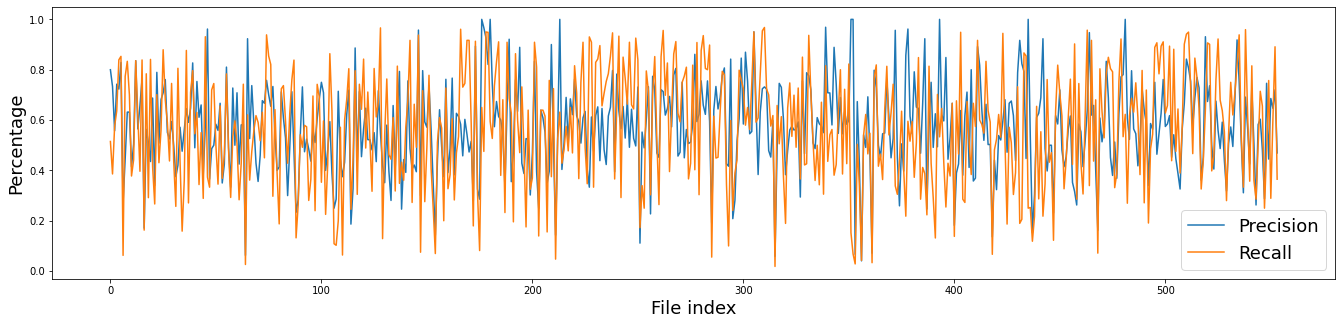


Testing classification: NO ELIMINATION + LEMMATISATION...
Average precision = 0.5738510750479205
Average recall = 0.5535375312589524
Average F1 = 0.5415971000364824


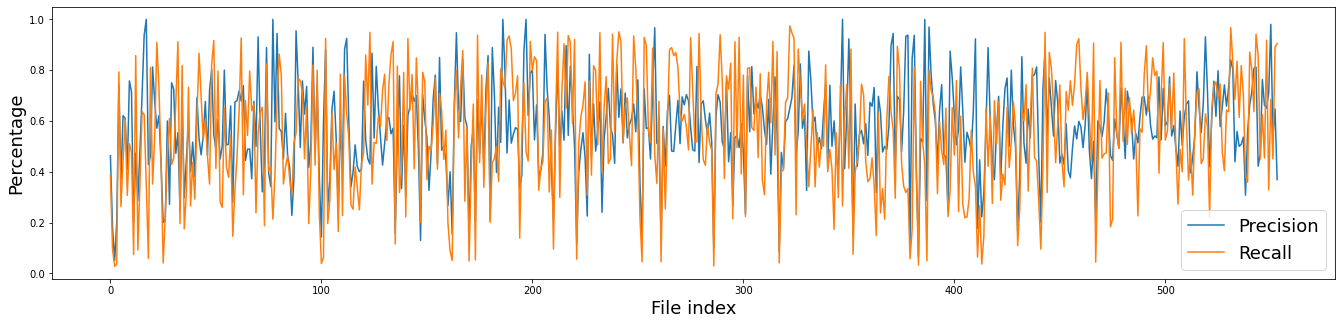


Testing classification: ELIMINATION + NO LEMMATISATION...
Average precision = 0.5125298558753473
Average recall = 0.6771919785657233
Average F1 = 0.5698907732271843


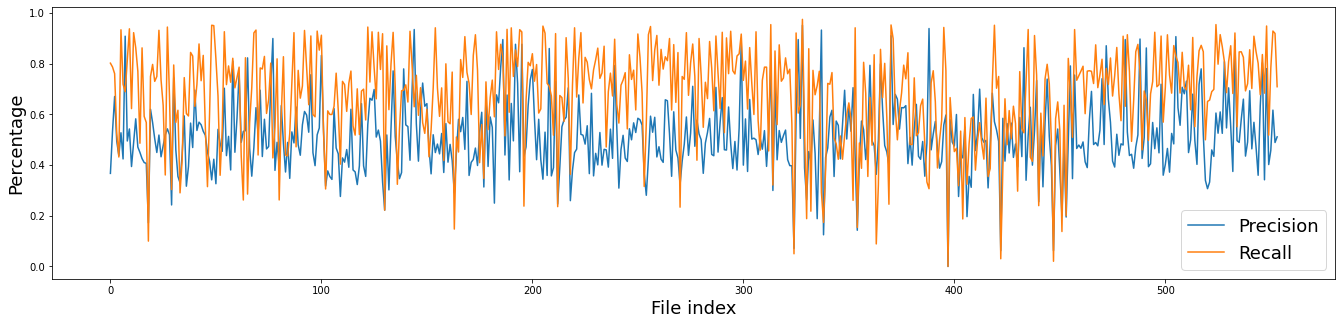


Testing classification: NO ELIMINATION + NO LEMMATISATION...
Average precision = 0.5100997130055639
Average recall = 0.650484544977828
Average F1 = 0.5576315561500031


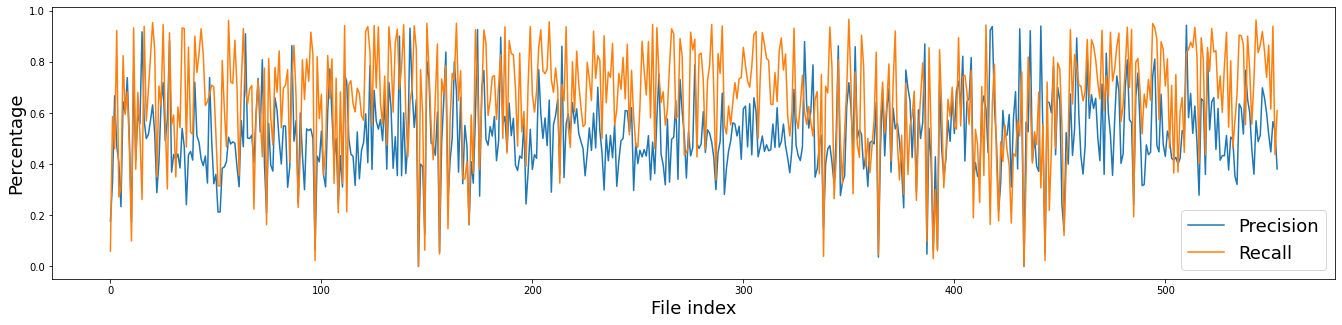

In [10]:
print("Testing summarisation: ELIMINATION + LEMMATISATION...")
test_classification('BBC News Summary', 'stop_words', True, True)
print("")

print("Testing summarisation: NO ELIMINATION + LEMMATISATION...")
test_classification('BBC News Summary', 'stop_words', False, True)
print("")

print("Testing summarisation: ELIMINATION + NO LEMMATISATION...")
test_classification('BBC News Summary', 'stop_words', True, False)
print("")

print("Testing summarisation: NO ELIMINATION + NO LEMMATISATION...")
test_classification('BBC News Summary', 'stop_words', False, False)
print("")